# GaP workflow

FILES WE NEED:
- input .d12 file (basis set, scf parameters)

INPUT FILES WE BUILD 
(PRIMITIVE CELL):
- OPTGEOM
- ELECTRONIC BAND STRUCTURE - DOS - EFFECTIVE MASS
- HIGH FREQ DIELECTRIC CONSTANT
- LOW FREQ DIELECTRIC CONSTANT
- PIZOELECTRIC CONSTANT
- ELASTIC CONSTANT

(SUPERCELL):
- 6X6X6 PHONONS 
- DISPERSION - DOS
- 4 0.1% DISPLACEMENTS 
- 


In [1]:
import copy
import os
from crystal_functions.file_readwrite import *
from pymatgen.symmetry.bandstructure import HighSymmKpath
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

from crystal_functions.convert import *
from crystal_functions.execute import *

## Primitive cell

### OPTGEOM

In [30]:
import sys 
sys.path.insert(-1,'../../../Imperial/crystal-code-tools/crystal_functions/crystal_functions/')

from file_readwrite import *
from convert import *
from plot import *
import numpy as np

gap_input_initial = Crystal_input().from_file('./data/GaP_input.d12')
gap_gui_initial = Crystal_gui().read_cry_gui('./data/GaP_input.gui')
gap_pmg_initial = cry_gui2pmg(gap_gui_initial)
gap_pmg_intial_prim = SpacegroupAnalyzer(gap_pmg_initial).get_primitive_standard_structure(international_monoclinic=False)

slurm_file_crystal = './data/slurm_file_crystal.slurm'

file = open(slurm_file_crystal, 'r')
slurm_file_crystal_data = file.readlines()
file.close()

slurm_file_properties = './data/slurm_file_properties.slurm'

file = open(slurm_file_properties, 'r')
slurm_file_properties_data = file.readlines()
file.close()

functional_list = ['HSE06', 'PBE', 'PBE0', 'PBESOL', 'PBESOL0', 'LDA', 'M06', 'BLYP', 'B3LYP', 'B2GPPLYP']
functional_details = [['HSE06\n'],
                     ['EXCHANGE\n','PBE\n','CORRELAT\n','PBE\n'],
                     ['PBE0\n'],
                     ['EXCHANGE\n','PBESOL\n','CORRELAT\n','PBESOL\n'],
                     ['PBESOL0\n'],
                     ['EXCHANGE\n','LDA\n','CORRELAT\n','PWLSD\n'],
                     ['M06\n'],
                     ['EXCHANGE\n','BECKE\n','CORRELAT\n','LYP\n'],
                     ['B3LYP\n'],
                     ['B2GPPLYP\n']]

opt_list = ['OPTGEOM\n','FULLOPTG\n','FRACTION\n','PRINTFORCES\n','PRINTOPT\n','ENDOPT\n']
cpks_list = ['EXTERNAL\n','CPKS\n','MAXCYCLE\n','500\n','TOLALPHA\n','4\n','FMIXING\n','20\n','END\n','END\n']
freq_list = ['EXTERNAL\n','FREQCALC\n','INTENS\n','INTPOL\n','END\n','END\n']
elapiezo_list = ['EXTERNAL\n','ELAPIEZO\n','END\n','END\n']

for i,functional in enumerate(functional_list):
    gap_input = copy.deepcopy(gap_input_initial)
    
    #OPTGEOM
    #folder = './data/optgeom/%s'%functional
    folder = './data/'
    if not os.path.exists(folder):           
            os.mkdir(folder)
    # write crystal input
    for line in opt_list:
        gap_input.geom_block.insert(-1,line)
     
    for line in functional_details[i]:
        gap_input.func_block.insert(-1,line)
    
    #write the OPTGEOM input and gui
    gap_input.write_crystal_input(os.path.join(folder,'GaP_%s_optgeom.d12'%functional))
    gap_gui_initial.write_crystal_gui(os.path.join(folder,'GaP_%s_optgeom.gui'%functional))
    
    #write the FREQCALC input and gui
    gap_input.geom_block = freq_list
    
    gap_input.write_crystal_input(os.path.join(folder,'GaP_%s_freq.d12'%functional))
    #gap_gui_initial.write_crystal_gui(os.path.join(folder,'GaP_%s_freq.gui'%functional))
    
    
    #write the CPKS input and gui
    gap_input.geom_block = cpks_list
    
    gap_input.write_crystal_input(os.path.join(folder,'GaP_%s_cpks.d12'%functional))
    #gap_gui_initial.write_crystal_gui(os.path.join(folder,'GaP_%s_cpks.gui'%functional))
    
    #write the ELAPIEZO input and gui
    gap_input.geom_block = elapiezo_list
    
    gap_input.write_crystal_input(os.path.join(folder,'GaP_%s_elapiezo.d12'%functional))
    
    #BANDS
    bands_input = Properties_input()
    bands_input.make_newk_block(12,24)    
    k_path = HighSymmKpath(gap_pmg_intial_prim)
    n_kpoints = 500
    first_band = 1
    last_band = 50
    bands_input.make_bands_block(k_path,n_kpoints,first_band,last_band)
    bands_input.write_properties_input(os.path.join(folder,'GaP_%s_bands.d3'%functional))
    
    #PDOSS
    doss_input = Properties_input()
    doss_input.make_newk_block(12,24)
    doss_input.make_pdoss_block(projections=[[1],[2]],proj_type='atom',n_points=500,band_range=[1,50],
                       plotting_option=1,poly=12,print_option=0)
    doss_input.write_properties_input(os.path.join(folder,'GaP_%s_doss.d3'%functional))
    
    #RUNCRY
    #runcry('./data/GaP_%s_optgeom'%functional)
    
    #RUNPROP
    #runprop('./data/GaP_%s_bands'%functional,'./data/GaP_%s_optgeom'%functional)
    #runprop('./data/GaP_%s_doss'%functional,'./data/GaP_%s_optgeom'%functional)
    
    #SLURM CRYSTAL PRIMITIVE
    # change directory
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm GaP_%s_optgeom &\n'%functional)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys GaP_%s_optgeom &\n'%functional)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')

    
    
with open('./data/GaP_crystal.slurm', 'w') as file:
    for line in slurm_file_crystal_data:
        file.writelines(line)


### OTHER PROP

In [76]:
import sys 
sys.path.insert(-1,'../../../Imperial/crystal-code-tools/crystal_functions/crystal_functions/')

from file_readwrite import *
from convert import *
from plot import *

gap_input_initial = Crystal_input().from_file('./data/GaP_input.d12')
gap_gui_initial = Crystal_gui().read_cry_gui('./data/GaP_input.gui')
gap_pmg_initial = cry_gui2pmg(gap_gui_initial)
gap_pmg_intial_prim = SpacegroupAnalyzer(gap_pmg_initial).get_primitive_standard_structure(international_monoclinic=False)

slurm_file_crystal = './data/slurm_file_crystal.slurm'

file = open(slurm_file_crystal, 'r')
slurm_file_crystal_data = file.readlines()
file.close()

slurm_file_properties = './data/slurm_file_properties.slurm'

file = open(slurm_file_properties, 'r')
slurm_file_properties_data = file.readlines()
file.close()

functional_list = ['HSE06', 'PBE', 'PBE0', 'PBESOL', 'PBESOL0', 'LDA', 'M06', 'BLYP', 'B3LYP']#, 'B2GPPLYP']
functional_details = [['HSE06\n'],
                     ['EXCHANGE\n','PBE\n','CORRELAT\n','PBE\n'],
                     ['PBE0\n'],
                     ['EXCHANGE\n','PBESOL\n','CORRELAT\n','PBESOL\n'],
                     ['PBESOL0\n'],
                     ['EXCHANGE\n','LDA\n','CORRELAT\n','PWLSD\n'],
                     ['M06\n'],
                     ['EXCHANGE\n','BECKE\n','CORRELAT\n','LYP\n'],
                     ['B3LYP\n']]
                     #['B2GPPLYP\n']]

#opt_list = ['OPTGEOM\n','FULLOPTG\n','FRACTION\n','PRINTFORCES\n','PRINTOPT\n','ENDOPT\n']
cpks_list = ['EXTERNAL\n','CPKS\n','MAXCYCLE\n','500\n','TOLALPHA\n','4\n','FMIXING\n','20\n','END\n','END\n']
freq_list = ['EXTERNAL\n','FREQCALC\n','INTENS\n','INTPOL\n','END\n','END\n']
elapiezo_list = ['EXTERNAL\n','ELAPIEZO\n','END\n','END\n']

for i,functional in enumerate(functional_list):
    
    gap_input = copy.deepcopy(gap_input_initial)
    
    for line in functional_details[i]:
        gap_input.func_block.insert(-1,line)
        
    
    gap_optgeom_out = Crystal_output().read_cry_output('./data/GaP_%s_optgeom.out'%(functional))
    gap_optgeom_pmg = cry_out2pmg(gap_optgeom_out,initial=False)
    gap_optgeom_gui = cry_pmg2gui(gap_optgeom_pmg)

    
    #write the FREQCALC input and gui
    gap_input.geom_block = freq_list
    
    gap_input.write_crystal_input(os.path.join(folder,'GaP_%s_freq.d12'%functional))
    gap_optgeom_gui.write_crystal_gui(os.path.join(folder,'GaP_%s_freq.gui'%functional))
    
    
    #write the CPKS input and gui
    gap_input.geom_block = cpks_list
    
    gap_input.write_crystal_input(os.path.join(folder,'GaP_%s_cpks.d12'%functional))
    gap_optgeom_gui.write_crystal_gui(os.path.join(folder,'GaP_%s_cpks.gui'%functional))
    
    #write the ELAPIEZO input and gui
    gap_input.geom_block = elapiezo_list
    
    gap_input.write_crystal_input(os.path.join(folder,'GaP_%s_elapiezo.d12'%functional))
    gap_optgeom_gui.write_crystal_gui(os.path.join(folder,'GaP_%s_elapiezo.gui'%functional))
    
    #BANDS
    bands_input = Properties_input()
    bands_input.make_newk_block(12,24)    
    k_path = HighSymmKpath(gap_pmg_intial_prim)
    n_kpoints = 500
    first_band = 1
    last_band = 50
    bands_input.make_bands_block(k_path,n_kpoints,first_band,last_band)
    bands_input.write_properties_input(os.path.join(folder,'GaP_%s_bands.d3'%functional))
    
    #PDOSS
    doss_input = Properties_input()
    doss_input.make_newk_block(12,24)
    doss_input.make_pdoss_block(projections=[[1],[2]],proj_type='atom',n_points=500,band_range=[1,50],
                       plotting_option=1,poly=12,print_option=0)
    doss_input.write_properties_input(os.path.join(folder,'GaP_%s_doss.d3'%functional))
    
    #RUNCRY
    #runcry('./data/GaP_%s_optgeom'%functional)
    
    #RUNPROP
    #runprop('./data/GaP_%s_bands'%functional,'./data/GaP_%s_optgeom'%functional)
    #runprop('./data/GaP_%s_doss'%functional,'./data/GaP_%s_optgeom'%functional)
    
    #SLURM CRYSTAL PRIMITIVE
    # change directory
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm GaP_%s_freq &\n'%functional)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys GaP_%s_freq &\n'%functional)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm GaP_%s_cpks &\n'%functional)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys GaP_%s_cpks &\n'%functional)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm GaP_%s_elapiezo &\n'%functional)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys GaP_%s_elapiezo &\n'%functional)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pprop_slurm GaP_%s_bands GaP_%s_optgeom &\n'%(functional,functional))
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm prop GaP_%s_bands &\n'%functional)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pprop_slurm GaP_%s_doss GaP_%s_optgeom &\n'%(functional,functional))
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm prop GaP_%s_doss &\n'%functional)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')

    
    
with open('./data/GaP_crystal_2.slurm', 'w') as file:
    for line in slurm_file_crystal_data:
        file.writelines(line)


24
24
24
24
24
24
24
24
24


In [3]:
gap_input.geom_block

['FULLOPTG\n',
 'FRACTION\n',
 'PRINTFORCES\n',
 'PRINTOPT\n',
 'ENDOPT\n',
 'OPTGEOM\n']

## Supercell

In [75]:
test = Crystal_output().read_cry_output('./data/primitive/GaP_PBE_optgeom.out')
test.get_last_geom()

[[[0.0, 2.75154845748, 2.75154845748],
  [2.75154845748, 0.0, 2.75154845748],
  [2.75154845748, 2.75154845748, 0.0]],
 [31, 15],
 [[0.0, 0.0, 0.0], [1.37577422874, 1.37577422874, 1.37577422874]]]

In [72]:
from pymatgen.io.phonopy import get_displaced_structures
from os.path import join
supercell_matrix = np.identity(3)*6

num_steps = 4

conv_matrix = np.array([[1., -1., -1.],[-1., 1., -1.],[-1.,-1.,1.]])
#gap_opt_conv = np.matmul(conv_matrix,set_cell(gap_opt,0.,conv_matrix).lattice.matrix)



functional_list = ['HSE06', 'PBE', 'PBE0', 'PBESOL', 'PBESOL0', 'LDA', 'M06', 'BLYP', 'B3LYP']#, 'B2GPPLYP']
functional_details = [['HSE06\n'],
                     ['EXCHANGE\n','PBE\n','CORRELAT\n','PBE\n'],
                     ['PBE0\n'],
                     ['EXCHANGE\n','PBESOL\n','CORRELAT\n','PBESOL\n'],
                     ['PBESOL0\n'],
                     ['EXCHANGE\n','LDA\n','CORRELAT\n','PWLSD\n'],
                     ['M06\n'],
                     ['EXCHANGE\n','BECKE\n','CORRELAT\n','LYP\n'],
                     ['B3LYP\n']]
                     #['B2GPPLYP\n']]

#opt_list = ['OPTGEOM\n','FULLOPTG\n','FRACTION\n','PRINTFORCES\n','PRINTOPT\n','ENDOPT\n']
cpks_list = ['EXTERNAL\n','CPKS\n','MAXCYCLE\n','500\n','TOLALPHA\n','4\n','FMIXING\n','20\n','END\n','END\n']
freq_list = ['EXTERNAL\n','FREQCALC\n','INTENS\n','INTPOL\n','END\n','END\n']
elapiezo_list = ['EXTERNAL\n','ELAPIEZO\n','END\n','END\n']

for i,functional in enumerate(functional_list):
    
    gap_input = copy.deepcopy(gap_input_initial)
    
    for line in functional_details[i]:
        gap_input.func_block.insert(-1,line)
        
    
        gap_optgeom_out = Crystal_output().read_cry_output('./data/GaP_%s_optgeom.out'%(functional))
        gap_optgeom_pmg = cry_out2pmg(gap_optgeom_out,initial=False)
        gap_optgeom_conv_pmg = SpacegroupAnalyzer(gap_optgeom_pmg).get_conventional_standard_structure()
        cell_step = gap_optgeom_conv_pmg.lattice.a*0.01

        for i,delta_c in enumerate(np.arange(0,num_steps+1)):   
            delta_cell = delta_c*cell_step
            #print(delta_cell)
            gap_pmg = set_cell(gap_optgeom_pmg,delta_cell,conv_matrix)
            
            folder = './data/supercell_6/'
        if not os.path.exists(folder):           
            os.mkdir(folder)
        
        disp_str = get_displaced_structures(gap_pmg,atom_disp=0.01, supercell_matrix=supercell_matrix)
        
        slurm_file = './data/slurm_file_crystal.slurm'

        file = open(slurm_file, 'r')
        data = file.readlines()
        file.close()
        data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm supercell_%s_%s-000\n'%(functional,delta_c))
        data.append('wait\n')
        data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys supercell_%s_%s-000\n'%(functional,delta_c))
        data.append('wait\n\n')
        data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm supercell_%s_%s-001 supercell_%s_%s-000\n'%(functional,delta_c,functional,delta_c))
        data.append('wait\n')
        data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys supercell_%s_%s-002\n'%(functional,delta_c))
        data.append('wait\n\n')
        data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm supercell_%s_%s-002 supercell_%s_%s-000\n'%(functional,delta_c,functional,delta_c))
        data.append('wait\n')
        data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys supercell_%s_%s-002\n'%(functional,delta_c))
        data.append('wait\n\n')
        
        with open('./data/supercell_6/supercell_%s.slurm'%functional, 'w') as file:
            for line in data:
                file.writelines(line)
                
        #displaced structures
        for k,struct in enumerate(disp_str):
                
            gap_scel_inp = Crystal_input().from_file(os.path.join('./data','GaP_input.d12'))
                      
            gap_disp_gui = cry_pmg2gui(struct,symmetry=False)
            
            gui_name = os.path.join(folder,'supercell_%s_%s-00%s.gui'%(functional,delta_c,k))
            gap_disp_gui.write_crystal_gui(gui_name,symm=False)
            
            
            if k > 0:
                gap_scel_inp.scf_block.insert(-1,'GUESSP\n')
            gap_scel_inp.scf_block.insert(-1,'MPP\n')
            
            gap_scel_inp.write_crystal_input(join(folder,'supercell_%s_%s-00%s.d12'%(functional,delta_c,k)))
            
        #### prepare slurm


        


        

In [49]:
gap_optgeom_out = Crystal_output().read_cry_output('./data/GaP_%s_optgeom.out'%(functional))
gap_optgeom_pmg = cry_out2pmg(gap_optgeom_out,initial=False)
SpacegroupAnalyzer(gap_optgeom_pmg).get_conventional_standard_structure()


Structure Summary
Lattice
    abc : 5.42122674778 5.42122674778 5.42122674778
 angles : 90.0 90.0 90.0
 volume : 159.32822477213776
      A : 5.42122674778 0.0 3.319543992060396e-16
      B : -3.319543992060396e-16 5.42122674778 3.319543992060396e-16
      C : 0.0 0.0 5.42122674778
PeriodicSite: Ga (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Ga (-0.0000, 2.7106, 2.7106) [0.0000, 0.5000, 0.5000]
PeriodicSite: Ga (2.7106, 0.0000, 2.7106) [0.5000, 0.0000, 0.5000]
PeriodicSite: Ga (2.7106, 2.7106, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: P (1.3553, 1.3553, 4.0659) [0.2500, 0.2500, 0.7500]
PeriodicSite: P (1.3553, 4.0659, 1.3553) [0.2500, 0.7500, 0.2500]
PeriodicSite: P (4.0659, 1.3553, 1.3553) [0.7500, 0.2500, 0.2500]
PeriodicSite: P (4.0659, 4.0659, 4.0659) [0.7500, 0.7500, 0.7500]

In [55]:
def set_cell(structure, delta_cell, conv_matrix):
    
    #to_rad = np.pi/180
    #to_deg = 180/np.pi
    
    import numpy as np
    from pymatgen.core.structure import Structure
    conv_matrix = np.array([[1.5, -.5, -.5],[-.5, 1.5, -.5],[-.5,-.5,1.5]])
    conv_matrix_inv = np.linalg.inv(conv_matrix)
    cubic_lattice = np.matmul(conv_matrix,structure.lattice.matrix)


    A = cubic_lattice[0,:]
    B = cubic_lattice[1,:]
    C = cubic_lattice[2,:]

    len_A = np.linalg.norm(cubic_lattice[0,:])
    len_B = np.linalg.norm(cubic_lattice[1,:])
    len_C = np.linalg.norm(cubic_lattice[2,:])

    A_norm = A/len_A
    B_norm = B/len_B
    C_norm = C/len_C

    ###
    cubic_lattice_new = np.zeros((3,3))
    cubic_lattice_new[0,:] = (cubic_lattice[0,:]/len_A) * (len_A+delta_cell)
    cubic_lattice_new[1,:] = (cubic_lattice[1,:]/len_B) * (len_B+delta_cell)
    cubic_lattice_new[2,:] = (cubic_lattice[2,:]/len_C) * (len_C+delta_cell)

    prim_lattice_new = np.matmul(conv_matrix_inv,cubic_lattice_new)
    
    return Structure(prim_lattice_new,structure.atomic_numbers,structure.frac_coords)

## Analysis
- energy
- band gap
- cell param ...

- plot bands
- plot doss

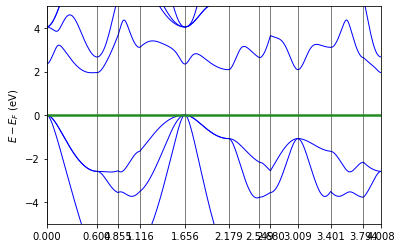

In [18]:
bands = Properties_output().read_cry_bands(
    'data/primitive/GaP_PBE_bands.BAND')
plot_cry_bands(
    bands, energy_range=[-5, 5])#, k_labels=['Gamma', 'M', 'K', 'A', 'L', 'H', 'K'], title='hTaAs')


In [19]:
k_path.